In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import json
import warnings

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_chemistry as fc
import flim_ui as fui
from ivium import load_ivium_file, IviumFile
import scipy.signal as sig
import scipy.optimize as optimize
from shapely import LineString

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09

In [2]:
data_folder = r"D:\[Code]\paper01\data"

In [3]:
"""FLIM data"""
current_data = fp.open_flim(
    os.path.join(data_folder, "current_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
current_features = fg.load_features(
    data_folder, "current_features.shp", "current_features.npz"
)
current_particle = [f for f in current_features if f.name == "particle"][0]
current_wall = [f for f in current_features if f.name == "wall"][0]
current_membrane = [f for f in current_features if f.name == "membrane"][0]
current_volume = [f for f in current_features if f.name == "volume"][0]

extent = fa.get_extent(current_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    current_data["intensity"][0].shape[1],
    0,
    current_data["intensity"][0].shape[0],
]

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    current_info = json.load(file)
current_timestamps_flim = np.array(
    list(current_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
current_delta_t_flim = current_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
current_ivium = IviumFile()
current_ivium.set_path(os.path.join(data_folder, "current_ivium1420.csv"))
current_ivium.read_data_from_file()

"""Timestamps"""
current_time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
current_flim_frames = fp.timestamp2frame_flim(
    current_time_stamps, current_info, offset_flim=-5
)["flim_frames"]

In [4]:
"""Open flim .json"""
with open(r"D:\[Code]\paper01\data\current.json", "r") as file:
    current_info = json.load(file)

"""Load Potential and Current data from ivium file"""
current_ivium = IviumFile()
current_ivium.set_path(r"D:\[Code]\paper01\data\current_ivium1420.csv")
current_ivium.read_data_from_file()

"""Timestamps and frames"""
time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
flim_frames = flim_frames = fp.timestamp2frame_flim(
    time_stamps, current_info, offset_flim=-5
)["flim_frames"]

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


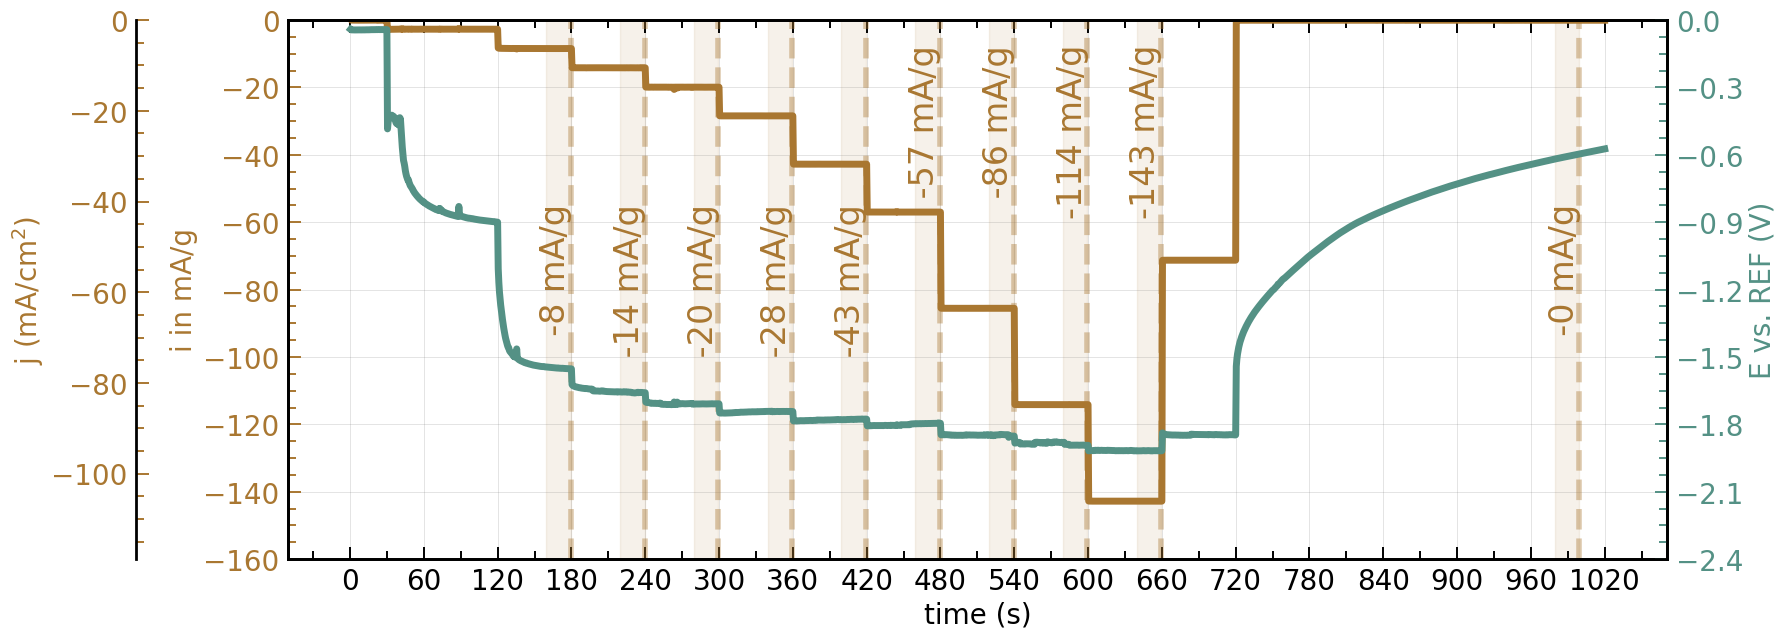

In [5]:
"""Color Map"""
cmap = plt.get_cmap("cmo.tarn")  # type:ignore
colors = cmap(np.linspace(0.25, 0.75, 2))

fig, ax = plt.subplots(figsize=(17.8, 7))

ax.set_ylabel(r"i in mA/g")
ax.set_xlabel("time (s)")
ax_ = ax.twinx()
ax_.set_ylabel("E vs. REF (V)")

ax.grid(alpha=0.3)
ax_.grid(alpha=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax.yaxis.label.set_color(colors[0])
ax.tick_params(axis="y", which="both", colors=colors[0])


def current_specific2density(x):
    return x * surface_area_AC / mass_particle_AC * 1e3 / 1e4


def current_density2specifc(x):
    return x * mass_particle_AC / surface_area_AC * 1e-3 / 1e-4


ax2 = ax.secondary_yaxis(
    -0.11, functions=(current_specific2density, current_density2specifc)
)
ax2.set_ylabel("j (mA/cm$^2$)")
ax2.yaxis.label.set_color(colors[0])  # type: ignore
ax2.tick_params(axis="y", which="both", colors=colors[0])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))  # type: ignore
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # type: ignore

ax_.yaxis.label.set_color(colors[-1])
ax_.tick_params(axis="y", which="both", colors=colors[-1])


ax.plot(current_ivium.t, current_ivium.I / mass_particle_AC, color=colors[0])
ax_.plot(current_ivium.t, current_ivium.E, color=colors[-1])

ax.set_ylim(-160, 0.0)
ax_.set_ylim(-2.4, 0.0)
ax.yaxis.set_major_locator(ticker.LinearLocator(9))
ax_.yaxis.set_major_locator(ticker.LinearLocator(9))
currents = []
potentials = []
for i_time, time_stamp in enumerate(time_stamps):
    x = current_ivium.t[current_ivium.t < time_stamp][-1]
    i = current_ivium.t[current_ivium.t < time_stamp][-1]
    current = current_ivium.I[current_ivium.t < time_stamp][-1]
    currents.append(current)
    potential = current_ivium.E[current_ivium.t < time_stamp][-20:].mean()
    potentials.append(potential)
    s = (
        f"{current_ivium.I[current_ivium.t < time_stamp][-1]  / mass_particle_AC:4.0f} "
        + r"mA/g"
    )
    ymin = current_ivium.I.min() / mass_particle_AC
    ymax = current_ivium.I.max() / mass_particle_AC
    ax.axvline(x=x, color=colors[0], alpha=0.4, ls="--", lw=4)
    ax.axvspan(x - 20, x, alpha=0.1, color=colors[0])

    if i_time < 6:
        y = 0 + ymin * 0.38
    else:
        y = 0 + ymin * 0.05
    ax.text(
        x=x + 1,
        y=y,
        s=s,
        rotation=90,
        horizontalalignment="right",
        verticalalignment="top",
        color=colors[0],
    )
fig.savefig(
    r"D:\[Code]\paper01\figures\current_EandI.png",
    transparent=True,
)
plt.show()

# Boundary Layer Calculations

In [6]:
ohminus = fc.ph2ohminus(current_data["value"])

In [7]:
distance_end_point = 200
number_rays = 360
pulling_bearing = 5

base_points = fa.get_points_along_line_number(
    current_particle.geometry.exterior, number_rays
)  # type:ignore
rays = fg.get_rays_of_sphere_like_base_points(base_points, pulling_bearing)

for i_ray, ray in enumerate(rays):
    ray.set_end_point_image(current_data["intensity"][0])
    ray.set_end_point_volume(current_volume.geometry)
    ray.set_end_point(distance_end_point)

ray_lines = []
for ray in rays:
    line = LineString([ray.base_point, ray.end_point_image])
    ray_lines.append(line)

chosen_ray_numbers = [-7, 35, 88, 172]
chosen_ray_numbers.reverse()
numerator_list = ["A", "B", "C", "D"]
chosen_rays = [rays[i] for i in chosen_ray_numbers]
v_alignments = ["center", "center", "baseline", "bottom"]
h_alignments = ["center", "center", "center", "center"]

90.0 76.4121410146139
89.0 79.17194249586737
88.0 76.58329674588765
87.0 73.55283430474537
86.0 72.62087712946834
85.0 71.52161833850028
84.0 69.73278419515412
83.0 68.53555575048358
82.0 66.45263714799034
81.0 63.703169400047784
80.0 60.636072482338136
79.0 59.535455723053076
78.0 61.45433744228353
77.0 63.13945547425982
76.0 65.53748457567178
75.0 69.59412217093382
74.0 71.96200465087134
73.0 69.82905849604845
72.0 71.43330221052395
71.0 68.89312589177086
70.0 68.07405180298736
69.0 68.9374630919375
68.0 66.56814318954389
67.0 70.03008048356662
66.0 67.5167615272523
65.0 67.75060720930014
64.0 67.1563915531043
63.0 65.53551970815727
62.0 63.30550707302507
61.0 63.61173227345773
60.0 66.29862064441329
59.0 65.36523377747045
58.0 65.37284800924601
57.0 65.4410693201284
56.0 61.224194477981825
55.0 58.3336278871372
54.0 58.74188505482226
53.0 55.766609219195686
52.0 58.289210691238736
51.0 56.766331800931766
50.0 56.581364882642106
49.0 62.335153396336466
48.0 54.2994618185499
47.0 56.4

In [8]:
rolling_window = 11
fraction_limit = 0.3
min_pixel = 10
ohminus_base = ohminus[-20:].mean(axis=0)

res0s = []
for ray in rays:
    res0 = ray.get_values_along_ray(
        ohminus_base, pixel_size=pixel_size, rolling_window=rolling_window
    )
    res0s.append(res0)


current_results = []

for i, (i_frame, time_stamp) in enumerate(
    zip(current_flim_frames, current_time_stamps)
):
    mean = ohminus[i_frame - 20 : i_frame + 1].mean(axis=0)
    # std = ohminus[i_frame-20:i_frame+1].std(axis = 0)
    current = np.round(
        abs(current_ivium.I[current_ivium.t < time_stamp][-1]) / mass_particle_AC, 2
    )
    print(i, i_frame, current)

    ray_results = []
    for i_ray, ray in enumerate(rays):
        res = ray.get_values_along_ray(
            mean, pixel_size=pixel_size, rolling_window=rolling_window
        )
        delta_oh_minus = res["values"] - res0s[i_ray]["values"]

        warnings.simplefilter("ignore")
        bulk_delta_oh_minus = delta_oh_minus[
            delta_oh_minus
            < (
                0.1 * (delta_oh_minus.min() + delta_oh_minus.max())
                + delta_oh_minus.min()
            )
        ].mean()
        warnings.warn("deprecated", DeprecationWarning)

        surface_delta_oh_minus = delta_oh_minus[:3].mean()
        peak_delta_oh_minus = surface_delta_oh_minus

        if i == 0:
            m = -9999
            peak = 0
            delta = 0
            peak_loc = 0
            fit_window_end = 0
        else:
            """radius of particle as benchmark"""
            benchmark_id = res["ray"][res["ray"] < radius_particle_AC * 1e6].size

            """peak detection"""
            try:
                peaks, properties = sig.find_peaks(
                    delta_oh_minus[:benchmark_id],
                    height=delta_oh_minus.max() * 0.7,
                    prominence=1e-5,
                )
                peak = peaks[np.argmax(properties["prominences"])]

                peak_delta_oh_minus = properties["peak_heights"][
                    np.argmax(properties["prominences"])
                ]
            except:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            if surface_delta_oh_minus >= peak_delta_oh_minus:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            xs = (
                res["ray"] / radius_particle_AC * 1e-6
            )  # dimensionless with particle radius
            ys = delta_oh_minus / peak_delta_oh_minus  # dimensionless y
            peak_loc = xs[peak]
            fit_window_end = peak

            """linear fit + boundary layer thickness calculation"""
            try:
                indices_below_threshold = np.where(ys[peak:] < fraction_limit)[0]
                fit_window_end = (
                    indices_below_threshold[
                        (indices_below_threshold - peak) > min_pixel
                    ][0]
                    + peak
                )
                ps, _ = optimize.curve_fit(
                    fa.linear,
                    xs[peak:fit_window_end],
                    ys[peak:fit_window_end],
                    p0=[-1, 1],
                )
                m = ps[0]
                n = ps[1]
                delta = -1 / m + peak_loc

            except ValueError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

            except IndexError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

        results = pd.Series(
            {
                "i_ray": i_ray,
                "image_angle": ray.angle,
                "current": current,
                "time": time_stamp,
                "count_frame": i,
                "lifa_frame": i_frame,
                "peak_id": peak,
                "fit_window_end": fit_window_end,
                "peak": peak_loc,
                "m": m,
                "delta": delta,
                "surface_delta_oh_minus": surface_delta_oh_minus,
                "peak_delta_oh_minus": peak_delta_oh_minus,
                "bulk_delta_oh_minus": bulk_delta_oh_minus,
            }
        )
        ray_results.append(results)
    ray_results_frame = pd.DataFrame(ray_results)
    ray_results_frame["sigma"] = np.sqrt(
        (
            (
                ray_results_frame.delta
                - fa.rollavg_convolve_circle(ray_results_frame.delta, 31)
            )
            / fa.rollavg_convolve_circle(ray_results_frame.delta, 31)
        )
        ** 2
    )
    current_results.append(ray_results_frame)
data = pd.concat(current_results, ignore_index=True)
data["flow_angle"] = data.image_angle.apply(fa.angle_image2flow)
data["i_ray"] = data.i_ray.astype("int")
data["lifa_frame"] = data.lifa_frame.astype("int")
data["count_frame"] = data.count_frame.astype("int")
data["distance"] = data.delta.astype("float") * radius_particle_AC
data["time"] = data.time.astype("float")
print(data.size)
data.to_csv(os.path.join(data_folder, "current_results.csv"))

0 1004 0.04
1 185 8.44
2 245 14.18
3 304 19.91
4 364 28.43
5 424 42.77
6 484 56.99
7 544 85.55
8 604 114.14
9 664 142.8
58888


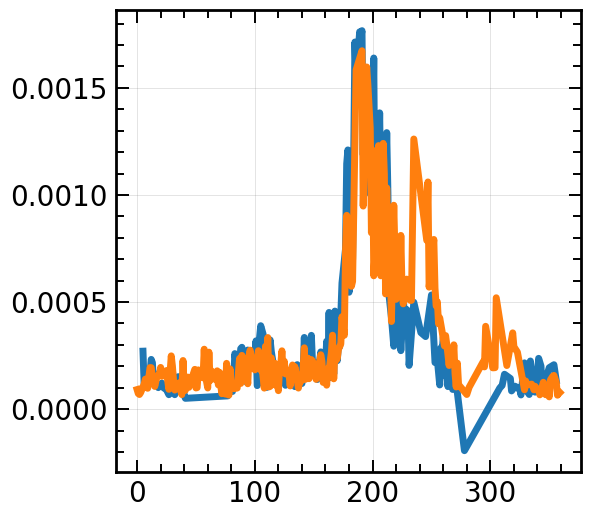

In [9]:
for i_frame_count, frame_count in enumerate(data.count_frame.unique()):
    if i_frame_count not in [4, 6]:
        continue
    d_current = data.query("(count_frame == @frame_count) & (sigma < 0.6)")
    plt.plot(d_current.i_ray, d_current.distance)

plt.show()

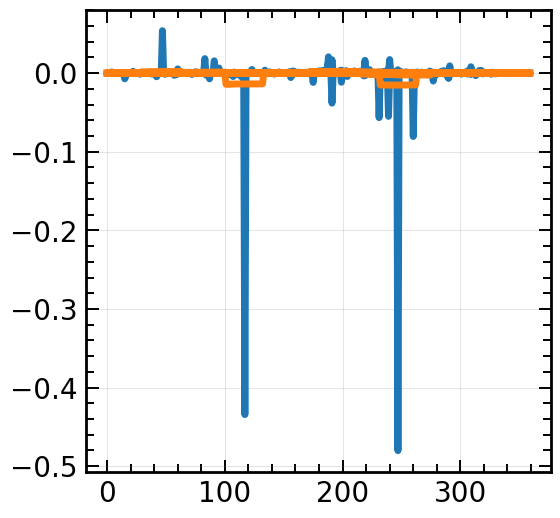

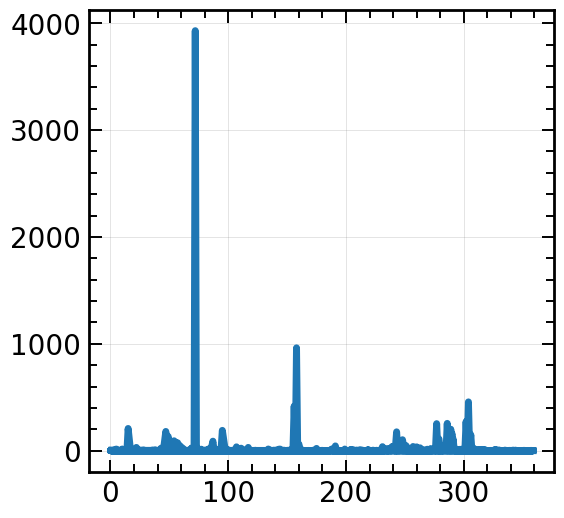

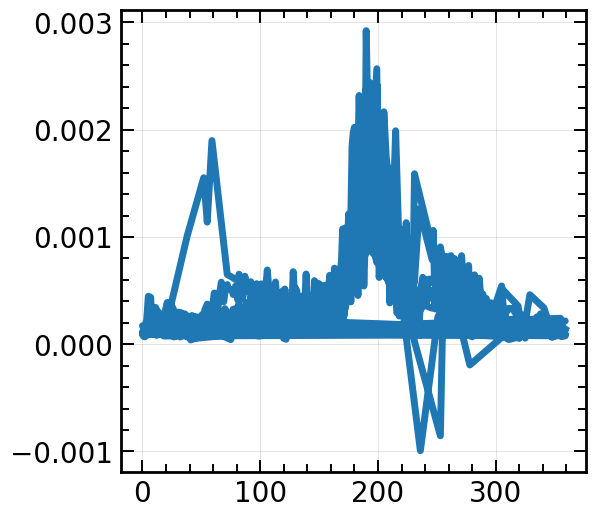

In [11]:
d = data.copy()#.query("sigma < 0.5")
# d = data_all.copy()

plt.plot(d.i_ray, d.distance)
plt.plot(d.i_ray, fa.rollavg_convolve_circle(d.distance, 31))
plt.show()
plt.plot(d.i_ray, d.sigma)
plt.show()

d_filtered = d.query("sigma < 0.5")
plt.plot(d_filtered.i_ray, d_filtered.distance)